In [1]:
# Tested with kernel "LCLS-II py3"

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline 
%config InlineBackend.figure_format ='retina'

In [2]:
import os
os.getcwd()

'/cds/home/b/bwt/MeV-UED'

In [3]:
from ued_data_analysis import file_to_h5, ord_dict, UED_Exp, find_center, quads_class

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import cm
from matplotlib.patches import Arrow, Circle
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from scipy import optimize


In [29]:
# now load multiple files in

fns = ['20201117_1825_quads.h5', '20201117_2133_quads.h5', '20201118_1554_quads_guess.h5', '20201118_2322_quads.h5']
ExpDict = {}

for f in fns:
    fn = f
    print(fn)
    Exp = quads_class()
    Exp.load_quads(fn)
    ExpDict[fn] = Exp


20201117_1825_quads.h5
20201117_1825_quads.h5
Keys: <KeysViewHDF5 ['delays_dict', 'delays_mask', 'delays_unique', 'quadsN_0', 'quadsN_1', 'quadsN_2', 'quadsN_3', 'stage_t0']>
delays_dict: <HDF5 group "/delays_dict" (29 members)>
delays_mask: <HDF5 dataset "delays_mask": shape (1050,), type "<i8">
delays_unique: <HDF5 dataset "delays_unique": shape (29,), type "<f8">
quadsN_0: <HDF5 dataset "quadsN_0": shape (1101, 450), type "<f8">
quadsN_1: <HDF5 dataset "quadsN_1": shape (1101, 450), type "<f8">
quadsN_2: <HDF5 dataset "quadsN_2": shape (1101, 450), type "<f8">
quadsN_3: <HDF5 dataset "quadsN_3": shape (1101, 450), type "<f8">
stage_t0: <HDF5 dataset "stage_t0": shape (1,), type "<f8">
delays_unique [161.273105   161.2880945  161.31057875 161.3180735  161.32556825
 161.333063   161.34055775 161.3480525  161.35554725 161.363042
 161.37053675 161.3780315  161.38552625 161.393021   161.40051575
 161.4080105  161.41550525 161.423      161.43049475 161.4379895
 161.44548425 161.452979   1

In [30]:
# This is what you have to work with!
[f for f in dir(Exp) if not f.startswith('__')]

['delays_dict',
 'delays_mask',
 'delays_unique',
 'filename',
 'load_quads',
 'maxRadius',
 'meanquadsN',
 'quadrants_stats',
 'quadsN',
 'save_quads',
 'set_params',
 'stage_t0',
 'stdquadsN',
 'useQuadrants']

In [31]:
list(Exp.delays_dict.keys())[0]

161.12321

In [32]:
[Exp for Exp in ExpDict.keys()]

['20201117_1825_quads.h5',
 '20201117_2133_quads.h5',
 '20201118_1554_quads_guess.h5',
 '20201118_2322_quads.h5']

(122, 450)


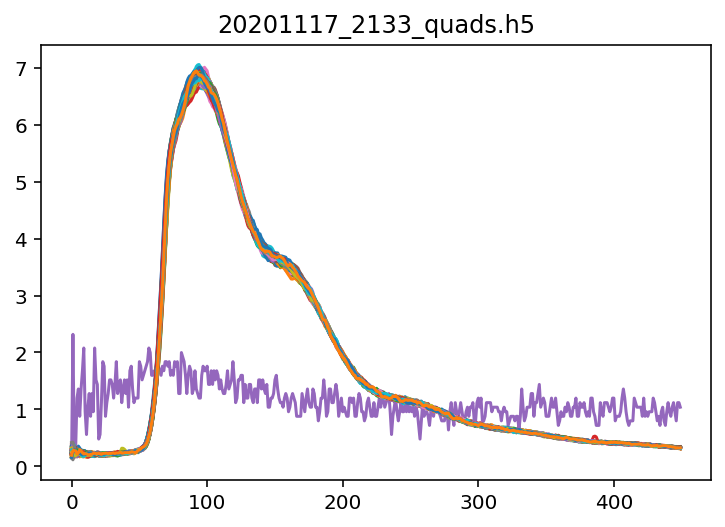

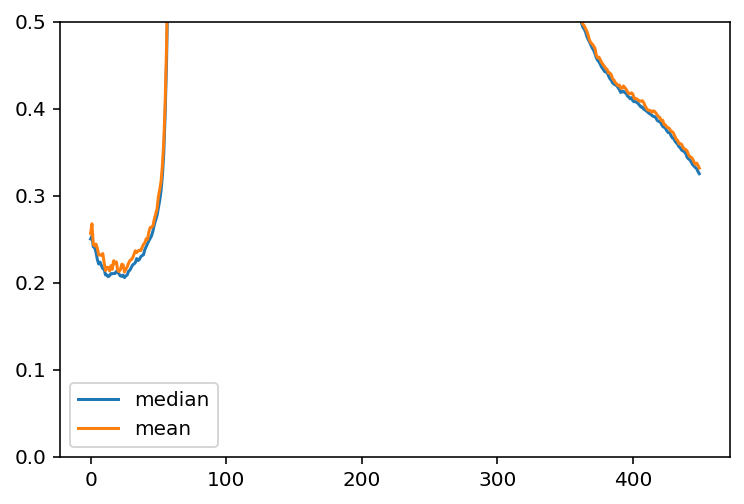

In [33]:
def plot_quadsN_v2(Exp_obj, delay=161.273105, quad=1):
    idxs = Exp_obj.delays_dict[delay]
    d = Exp_obj.quadsN[idxs,:,quad]
    print(d.shape)
    plt.title(Exp_obj.filename)
    plt.plot(np.transpose(d))
    plt.show()
    
    plt.plot(np.median(d, axis=0), label='median')
    plt.plot(np.mean(d, axis=0), label='mean')
    plt.legend()
    plt.ylim(0,0.5)
    plt.show()
    
plot_quadsN_v2(ExpDict['20201117_2133_quads.h5'])    

In [34]:
def plot_2Ddata(Exp, vscale=0.03):
    
    tmp = np.mean(Exp.meanquadsN,axis=-1)
    data = tmp - np.mean(tmp[-5:-1],axis=0) # subtract negative time
    print(data.shape)
    
    taxis = Exp.delays_unique
    qaxis = np.linspace(0,Exp.maxRadius*0.02355,Exp.maxRadius)
    fig, ((ax1)) = plt.subplots(ncols=1, nrows = 1, figsize=(4,3))
    cartim1 = ax1.pcolormesh(qaxis,taxis,data, shading='auto', cmap=cm.bwr, vmin=-vscale, vmax=vscale)
    ax1.set_title(Exp.filename)
    ax1.xaxis.set_minor_locator(AutoMinorLocator(10))
    ax1.set_xlim(0,10)
    ax1.set_xlabel('Q / $\AA^{-1}$', fontsize='large'), ax1.set_ylabel('delay (fs)', fontsize='large')
    cbar = plt.colorbar(cartim1, ax=ax1)
    cbar.set_label("(t - t<0) change in diffraction", fontsize='large')

(31, 450)


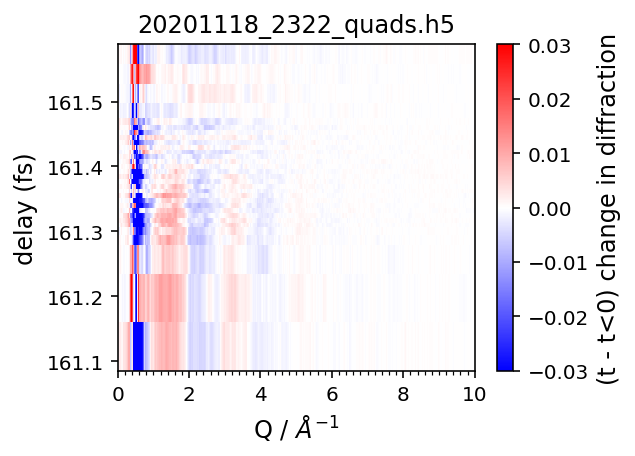

In [35]:
Exp = ExpDict['20201118_2322_quads.h5']
plot_2Ddata(Exp)

(29, 450)
(33, 450)
(31, 450)
(31, 450)


[None, None, None, None]

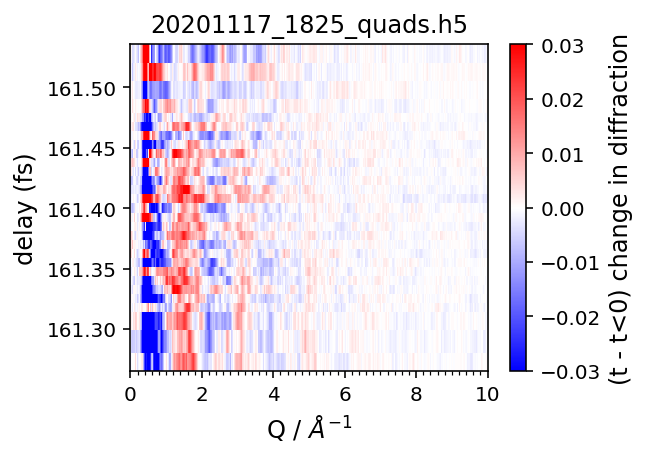

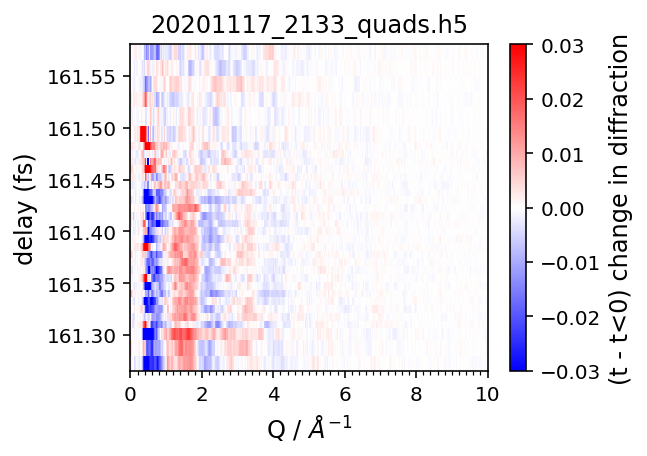

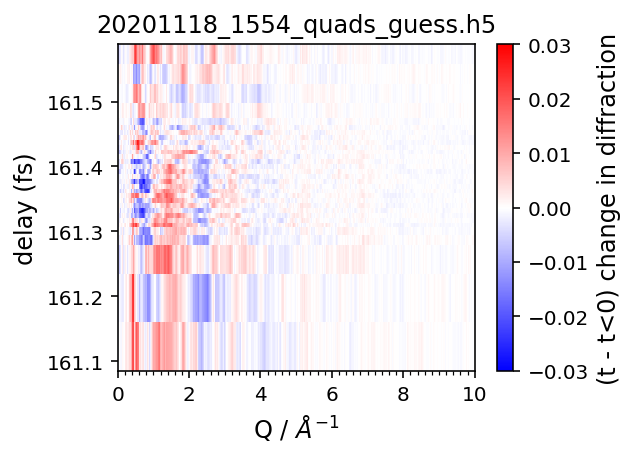

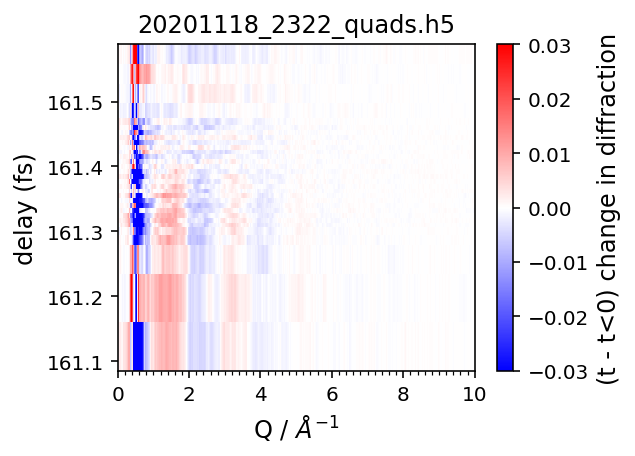

In [36]:
[plot_2Ddata(ExpDict[key]) for key in ExpDict.keys()]

In [13]:
#how to take mean of multiple datasets if the taxis doesn't line up? round?/bin onto a ~50 fs axis? interpolate?

In [14]:
import pandas as pd

In [18]:
def pandas_2Ddata(Exp):
    """This function sets up a pandas DataFrame for a specific Exp. run, retrieving properties in the Exp object to define time axis"""
    tmp = np.mean(Exp.meanquadsN,axis=-1)
    data = tmp - np.mean(tmp[-5:-1],axis=0) # subtract negative time
    
    c = 299792458
    t_offset = 0
    t_fs = t_offset + (Exp.delays_unique-Exp.stage_t0)*2*c/1E5
    
    df = pd.DataFrame(data, index=t_fs)
    df["filename"] = Exp.filename

    return df

In [19]:
df = pandas_2Ddata(Exp)

In [20]:
df;

In [21]:
# Make a list of DataFrames
print(ExpDict.keys())
dfs = [pandas_2Ddata(ExpDict[key]) for key in ExpDict.keys()]

dict_keys(['20201117_1825_quads.h5', '20201117_2133_quads.h5', '20201118_1554_quads.h5', '20201118_2322_quads.h5'])


In [22]:
# First attempt: Use only indexes where each Exp run as a value for that delay/index
df_all = pd.concat(dfs, join='inner') # inner means we only use indexes (times) with values in all datasets. Drops all indexes that exist in all dataframes!

In [23]:
df_all.index

Float64Index([ -898.7478098382899,  -808.8730288543927,  -674.0608573787174,
               -629.1234668867688,  -584.1860763948202,  -539.2486859028717,
               -494.3112954110935, -449.37390491914493, -404.43651442719636,
               -359.4991239352478,
              ...
                44.93739049194858,   89.87478098372674,   134.8121714756753,
                179.7495619676239,  224.68695245957247,  269.62434295152104,
                359.4991239352478,   539.2486859028717,   718.9982478704956,
                898.7478098381195],
             dtype='float64', length=124)

In [24]:
df_all.loc[898.7478098381195] # Only 3 of the 4 datasets have this delay/index

,0,1,2,3,4,5,6,7,8,9,...,441,442,443,444,445,446,447,448,449,filename
898.74781,0.007049,-0.000554,0.000091,-0.000487,0.000351,0.001488,0.000753,0.001671,0.001826,-0.000181,...,0.000443,0.000889,0.000448,0.000216,0.000260,0.000094,0.000344,0.000346,0.000461,20201117_2133_quads.h5
898.74781,-0.012256,-0.009374,-0.009752,-0.004102,-0.001452,-0.000448,-0.001088,-0.001305,-0.002991,-0.001998,...,-0.000743,-0.000704,-0.000357,0.000140,-0.000494,-0.000557,-0.001001,-0.001161,-0.000751,20201118_1554_quads.h5
898.74781,0.000278,-0.000228,0.001156,0.000901,0.000850,0.000976,-0.000222,-0.000287,0.000786,-0.000445,...,0.000213,0.000191,0.000080,0.000093,0.000147,0.000184,0.000319,0.000422,0.000329,20201118_2322_quads.h5


In [25]:
# Take the mean over all dataframes
df_mean = df_all.groupby(df_all.index).mean()

In [26]:
df_mean.index

Float64Index([-1797.4956196764094, -1348.1217147572643,  -898.7478098382899,
               -808.8730288543927,  -718.9982478704956,  -674.0608573787174,
               -629.1234668867688,  -584.1860763948202,  -539.2486859028717,
               -494.3112954110935, -449.37390491914493, -404.43651442719636,
               -359.4991239352478,  -314.5617334432992, -269.62434295152104,
              -224.68695245957247,  -179.7495619676239,  -134.8121714756753,
               -89.87478098389715,  -44.93739049194858,                 0.0,
                44.93739049194858,   89.87478098372674,   134.8121714756753,
                179.7495619676239,  224.68695245957247,  269.62434295152104,
                314.5617334432992,   359.4991239352478,  404.43651442719636,
               449.37390491914493,   539.2486859028717,   629.1234668867688,
                718.9982478704956,   808.8730288543927,   898.7478098381195],
             dtype='float64')

In [27]:
def plot_mean2Ddata(df, vscale=0.03):
    
    data = df.to_numpy()
    print(data.shape)
    taxis = df.index
    qaxis = np.linspace(0,Exp.maxRadius*0.02355,Exp.maxRadius)
    
    fig, ((ax1)) = plt.subplots(ncols=1, nrows = 1, figsize=(4,3))
    cartim1 = ax1.pcolormesh(qaxis,taxis,data, shading='auto', cmap=cm.bwr, vmin=-vscale, vmax=vscale)
    ax1.set_title("Mean of all datasets")
    ax1.xaxis.set_minor_locator(AutoMinorLocator(10))
    ax1.set_xlim(0,5)
    ax1.set_ylim(-700,700)
    ax1.set_xlabel('Q / $\AA^{-1}$', fontsize='large'), ax1.set_ylabel('delay (fs)', fontsize='large')
    cbar = plt.colorbar(cartim1, ax=ax1)
    cbar.set_label("(t - t<0) change in diffraction", fontsize='large')

(36, 450)


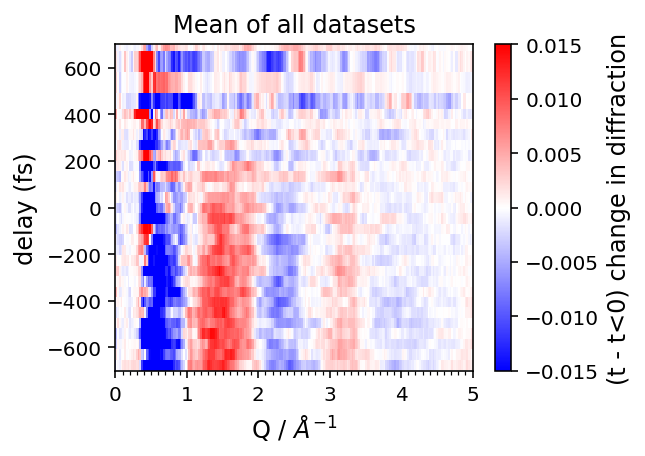

In [39]:
plot_mean2Ddata(df_mean, vscale=0.015)